# Lab 07: Genetic Algorithms

## Total: 50 points

In this lab, you'll explore the fundamentals of genetic algorithms by implementing core operations like selection, crossover, and mutation. We give you the initialization code and fitness function so you can focus the different ways to implement core operations.

## General Instructions

- Carefully read through the commented helper functions.
- Implement the missing functions where marked with `pass`.
- This lab is VERY open ended! There isn't one way to do this. Implement the strategies or verisons that interest you!
- **We have provided suggested parameters to pass into the unimplemented functions, but depending on the methods you pick, the parameters might change or you will need additional ones. Make sure to edit the parameter list for methods and strategies you use!!** 

In [80]:
import random
import matplotlib.pyplot as plt
import time

In [81]:
# Problem Constants
#fr bro we need to know how many days are in a week? 
NUM_PEOPLE = 3
SHIFTS_PER_DAY = 3
DAYS_PER_WEEK = 7
SHIFTS_PER_WEEK = SHIFTS_PER_DAY * DAYS_PER_WEEK # 21

In [82]:
# GA Parameters
POPULATION_SIZE = 100       # Number of schedules in each generation
GENERATIONS = 150           # Number of generations to run
MUTATION_RATE = 0.02        # Probability of a single bit flip mutation
CROSSOVER_RATE = 0.7        # Probability that crossover occurs between two parents
HARD_PENALTY = -2           # Penalty per violated hard constraint
SOFT_PENALTY = -1           # Penalty per violated soft constraint

# Helper Functions

In [83]:
## Helper Functions
def get_shift_details(shift_index):
    """
    Calculates day (0-6) and shift type (0=M, 1=A, 2=N) from shift index (0-20).

    Args:
        shift_index (int): The shift index (0-20)

    Returns:
        day (int): The day of the week (0-6)
        shift_type (int): The shift type (0=M, 1=A, 2=N)
    """
    if not (0 <= shift_index < SHIFTS_PER_WEEK):
        raise ValueError(f"shift_index {shift_index} out of range [0, {SHIFTS_PER_WEEK-1}]")
    day = shift_index // SHIFTS_PER_DAY
    shift_type = shift_index % SHIFTS_PER_DAY
    return day, shift_type

def print_schedule(schedule, fitness):
    """
    Prints the schedule in a readable format.

    Args:
        schedule (list): The schedule to print
        fitness (float): The fitness score of the schedule
    """
    print(f"\nSchedule (Fitness: {fitness:.2f}):")
    days = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
    shifts = ["M", "A", "N"]
    header = "      " + " | ".join([days[d] for d in range(DAYS_PER_WEEK)])
    print(header)
    subheader = "      " + " ".join([f"{s}" for _ in days for s in shifts])
    print(subheader)
    print("      " + "-" * (len(subheader)-1))
    for person_idx, person_schedule in enumerate(schedule):
        schedule_str = ""
        for i in range(SHIFTS_PER_WEEK):
             schedule_str += str(person_schedule[i])
             if (i + 1) % SHIFTS_PER_DAY == 0 and i < SHIFTS_PER_WEEK - 1:
                 schedule_str += " " # Add space between days
        print(f"ATC {person_idx+1}: {schedule_str}")
    print("-" * (len(subheader) + 5))

def plot_fitness(fitness_history):
    """
    Plots the best and average fitness score per generation.

    Args:
        fitness_history (list): A list of fitness scores for each generation

    Returns:
        None
    """
    plt.figure(figsize=(12, 6))
    generations = range(1, len(fitness_history) + 1)
    plt.plot(generations, fitness_history, marker='o', linestyle='-', label='Best Fitness')
    plt.title('GA Fitness Progression for ATC Scheduling')
    plt.xlabel('Generation')
    plt.ylabel('Fitness Score (Higher is Better)')
    # Set y-limit to start slightly below the minimum fitness achieved or a reasonable lower bound
    min_fitness = min(fitness_history)
    plt.ylim(bottom=min(min_fitness - 5, -50)) # Adjust y-axis floor
    plt.legend()
    plt.grid(True)
    plt.show()

def repair_schedule(schedule):
    """
    Enforces rest constraints on a binary-encoded schedule
    
    Args: 
        schedule: list of schedule
    
    Returns:
        repaired: list of schedule that still satisfies constraints
    """
    repaired = [ctrl.copy() for ctrl in schedule]
    for ctrl_idx in range(len(repaired)):
        for shift_idx in range(len(repaired[ctrl_idx])):
            if repaired[ctrl_idx][shift_idx] == 1:
                day, shift_type = get_shift_details(shift_idx)
                
                # after morning/afternoon next shift must be off
                if shift_type in [0, 1] and (shift_idx + 1) < len(repaired[ctrl_idx]):
                    repaired[ctrl_idx][shift_idx + 1] = 0
                
                # after night next day must be off
                elif shift_type == 2:
                    next_day = day + 1
                    if next_day < DAYS_PER_WEEK:
                        next_start = next_day * SHIFTS_PER_DAY
                        for s in range(next_start, min(next_start + SHIFTS_PER_DAY, len(repaired[ctrl_idx]))):
                            repaired[ctrl_idx][s] = 0
    return repaired

## Initialization

Helper code to create the initial population. Make sure you understand how we have chosen to represent the individual and population!

In [84]:
# Init GA
def generate_initial_representation(num_people, shifts_per_week):
  """
  Creates a single random schedule representation (chromosome).
  Each person gets a list of 0s and 1s for the week's shifts.

  Args:
    num_people (int): The number of people in the schedule.
    shifts_per_week (int): The number of shifts per week.

  Returns:
    schedule (list): A list of lists, where each inner list represents a person's schedule for the week.
  """
  schedule = []
  for _ in range(num_people):
    person_schedule = [random.choice([0, 1]) for _ in range(shifts_per_week)]
    schedule.append(person_schedule)
  return schedule

def generate_population(population_size, num_people, shifts_per_week):
  """ Creates the initial population of random schedules. """
  return [generate_initial_representation(num_people, shifts_per_week)
          for _ in range(population_size)]

## Fitness Function

Evaluate how close a candidate is to the target solution. Note how hard versus soft constraints are handled.

In [85]:
def evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day):
    """ 
    Calculates the fitness of a single schedule based on constraints. 

    Args:
        schedule (list): The schedule to evaluate
        num_people (int): The number of people in the schedule
        shifts_per_week (int): The number of shifts per week
        shifts_per_day (int): The number of shifts per day

    Returns:
        fitness (float): The fitness score of the schedule
    """
    fitness = 0 # Start with perfect fitness, subtract penalties

    # Hard Constraint Checks

    # 1. Minimum controllers per shift
    min_controllers = {0: 1, 1: 2, 2: 1} # M:1, A:2, N:1
    shift_violations = 0
    for shift_idx in range(shifts_per_week):
        _, shift_type = get_shift_details(shift_idx)

        # Calculate number of controllers on this shift
        controllers_on_shift = sum(schedule[p][shift_idx] for p in range(num_people))
        required = min_controllers[shift_type]

        # Penalize for each missing controller
        if controllers_on_shift < required:
            fitness += HARD_PENALTY * (required - controllers_on_shift)
            shift_violations += (required - controllers_on_shift)

    # 2. Rest periods
    rest_violations = 0
    for p in range(num_people):
        for shift_idx in range(shifts_per_week):
            if schedule[p][shift_idx] == 1: # If person p works this shift
                _, shift_type = get_shift_details(shift_idx)

                # a) Rest after Morning (0) or Afternoon (1)
                if shift_type in [0, 1]:
                    next_shift_idx = shift_idx + 1
                    # Check boundary: ensure next shift is within the week
                    if next_shift_idx < shifts_per_week and schedule[p][next_shift_idx] == 1:
                         fitness += HARD_PENALTY # Violation: Working the very next shift
                         rest_violations += 1

                # b) Rest after Night (2)
                elif shift_type == 2:
                    # Check the next 3 shifts (full day)
                    violation_found_for_night_shift = False
                    for i in range(1, shifts_per_day + 1):
                        next_shift_idx = shift_idx + i
                        # Check boundary: ensure check stays within the week
                        if next_shift_idx < shifts_per_week and schedule[p][next_shift_idx] == 1:
                            if not violation_found_for_night_shift: # Only penalize once per night shift violation
                                fitness += HARD_PENALTY
                                rest_violations += 1
                                violation_found_for_night_shift = True
                            # No need to check further shifts for *this* night shift once violation is found

    # Soft Constraint Checks

    # 1. Excess controllers in tower
    excess_violations = 0
    for shift_idx in range(shifts_per_week):
        _, shift_type = get_shift_details(shift_idx)
        controllers_on_shift = sum(schedule[p][shift_idx] for p in range(num_people))
        required = min_controllers[shift_type]
        if controllers_on_shift > required:
            excess = controllers_on_shift - required
            fitness += SOFT_PENALTY * excess # Penalize for each extra controller
            excess_violations += excess

    # A fitness of 0 means no constraints were violated. Higher (less negative) is better.
    # You could also return the counts of violations for analysis if needed:
    # return fitness, shift_violations, rest_violations, excess_violations
    return fitness

## Q1.1 Parent Selection (4 points)

In this step, pick the parents chosen for crossover. Recall there are lots of different ways this can fit together with the crossover step. It's up to you on which method you pick.

In [86]:
def parent_selection(population, fitness_scores):
    """
    selects parents using tournament selection

    Args:
        population: list of individuals 
        fitness_scores: list of corresponding fitness scores
    
    Returns:
        selected_parents: list of parents selected
    """
    selected_parents = []
    for _ in range(len(population)):
        # picks 3 individuals randomly with their fitnesses
        tournament = random.sample(list(zip(population, fitness_scores)), 3)
        # selects individual with highest fitness
        winner = max(tournament, key=lambda x: x[1])[0]
        selected_parents.append(winner)
    return selected_parents

## Q1.2 Crossover (4 points)

In this step, you combine two (or more) parent chromosomes to produce an offspring (or more). Recall that you can use the CROSSOVER_RATE parameter.

In [87]:
def crossover(parent_1, parent_2, num_people, shifts_per_week, crossover_rate):
    """
    performs uniform crossover between two parents to generate two offspring schedules
        
    Args:
        parent_1: list of first parent
        parent_2: list of second parent
        num_people: int of atc workers
        shifts_per_week: int of shift in a week
        crossover_rate: float probability of parent crossover
    
    Returns:
        child1: list of first child schedule
        child2: list of second child schedule
    """
    if random.random() > crossover_rate:
        return parent_1.copy(), parent_2.copy()
    
    child_1 = []
    child_2 = []
    for ctrl_idx in range(num_people):
        c1 = []
        c2 = []
        for shift_idx in range(shifts_per_week):
            if random.choice([True, False]):
                c1.append(parent_1[ctrl_idx][shift_idx])
                c2.append(parent_2[ctrl_idx][shift_idx])
            else:
                c1.append(parent_2[ctrl_idx][shift_idx])
                c2.append(parent_1[ctrl_idx][shift_idx])
        child_1.append(c1)
        child_2.append(c2)
    
    # repair to make sure constraints are still satisfied
    child_1 = repair_schedule(child_1)
    child_2 = repair_schedule(child_2)
    return child_1, child_2

## Q1.3 Mutation (4 points)

Add random mutations to chromosomes to maintain genetic diversity. You'll implement a function that randomly changes characters in the chromosome string. Recall that you can use the MUTATION_RATE parameter.

In [88]:
def mutate(schedule, mutation_rate, num_people, shifts_per_week):
    """
    Mutates a schedule by randomly altering shifts while enforcing rest constraints. 
    After M/A/N, the next day is set to Off. Previous shifts block invalid mutations.

    Args:
        schedule: list of controller schedules
        mutation_rate: float probability of mutation rate
        num_people: int of atc workers
        shifts_per_week: int of shifts in a week

    Returns:
        list of mutated schedule
    """
    mutated = [ctrl.copy() for ctrl in schedule]
    for ctrl_idx in range(num_people):
        for shift_idx in range(shifts_per_week):
            # skip mutation if the previous shift was worked so we still satisfy the constraint
            day, shift_type = get_shift_details(shift_idx)
            if shift_idx > 0 and mutated[ctrl_idx][shift_idx-1] == 1:
                mutated[ctrl_idx][shift_idx] = 0  
                continue
            if random.random() < mutation_rate:
                mutated[ctrl_idx][shift_idx] = 1 if mutated[ctrl_idx][shift_idx] == 0 else 0
    return repair_schedule(mutated)

## Q1.4 Selection (4 points)

You will implement a method for selecting parent chromosomes based on their fitness scores. The better the fitness, the higher the chance of selection.

In [89]:
def select_survivors(population, offspring_population, population_size, num_people, shifts_per_week, shifts_per_day, days_per_week):
    """
    selects the survivors maintaining the top 10% of parents and fills the rest with combined parents/offspring

    Args:
        population: list of current parent schedules
        offspring_population: lost of offspring schedules
        population_size: int size of new generation
        num_people: int of atc workers
        shifts_per_week: int of shifts in a week
        shifts_per_day: int of shifts in a day
        days_per_week: int of days in a week
        

    Returns:
        survivors: list of survivors
    """
    # combine the parents and the offspring
    combined = population + offspring_population

    # calculates fitness for all individuals
    fitness_scores = [evaluate_fitness(ind, num_people, shifts_per_week, shifts_per_day) for ind in combined]
    combined_with_fitness = list(zip(combined, fitness_scores))
    sorted_combined = [ind for ind, _ in sorted(combined_with_fitness, key=lambda x: x[1], reverse=True)]

    # selects elites (best 10% of parents)
    num_elites = int(0.1 * population_size)
    parent_indices = {id(p): i for i, p in enumerate(population)}
    parent_fitness = []
    for i, (ind, fit) in enumerate(combined_with_fitness):
        if id(ind) in parent_indices:
            parent_fitness.append((fit, ind))
    parent_fitness_sorted = sorted(parent_fitness, key=lambda x: x[0], reverse=True)
    elites = [ind for (fit, ind) in parent_fitness_sorted[:num_elites]]

    # selects survivors
    survivors = elites.copy()
    for ind in sorted_combined:
        if len(survivors) >= population_size:
            break
        if ind not in elites:
            survivors.append(ind)

    return survivors

## Q1.5 Putting It All Together (4 points)

Finally, integrate all components into a loop to simulate multiple generations of evolution.

In [90]:
def genetic_algorithm(population_size, num_people, shifts_per_week, shifts_per_day, days_per_week,
                      generations, mutation_rate, crossover_rate, parent_func=parent_selection, cross_func=crossover):
    """
    Runs the whole GA

    Args:
        population_size: int of schedules for each generation
        num_people: int of atc workers
        shifts_per_week: int of shifts in a week
        shifts_per_day: int of shifts in a day
        days_per_week: int of days in a week
        generations: int of generations to evolve through
        mutation_rate: float probability of mutation rate
        crossover_rate: float probability of parent crossover
        parent_func: decides which parent function to use
        cross_func: decides which crossover function to use

    Returns:
        best_schedule: list representing the best schedule in the run
        best_fitness: float representing the best fitness of the run
        fitness_history: list of all the fitnesses in the run
    """
    
    population = generate_population(population_size, num_people, shifts_per_week)
    best_fitness = float('-inf')
    best_schedule = None
    fitness_history = []

    for gen in range(generations):
        # evaluates fitness
        fitness_scores = [evaluate_fitness(ind, num_people, shifts_per_week, shifts_per_day) 
                          for ind in population]
        
        #updated the best soln
        current_best_idx = max(range(len(fitness_scores)), key=lambda i: fitness_scores[i])
        current_best = fitness_scores[current_best_idx]
        if current_best > best_fitness:
            best_fitness = current_best
            best_schedule = [row.copy() for row in population[current_best_idx]]
        fitness_history.append(current_best)

        # selects parents
        parents = parent_func(population, fitness_scores)

        # generating offspring
        offspring = []
        for i in range(0, len(parents), 2):
            p1, p2 = parents[i], parents[(i+1)%len(parents)]
            c1, c2 = cross_func(p1, p2, num_people, shifts_per_week, crossover_rate)
            offspring.extend([mutate(c1, mutation_rate, num_people, shifts_per_week),
                             mutate(c2, mutation_rate, num_people, shifts_per_week)])

        population = select_survivors(population, offspring, population_size, num_people,
                                     shifts_per_week, shifts_per_day, days_per_week)

    return best_schedule, best_fitness, fitness_history

# Main

Run the genetic algorithm and plot the fitness scores.


      Best Schedule Found

Schedule (Fitness: -12.00):
      Sun | Mon | Tue | Wed | Thu | Fri | Sat
      M A N M A N M A N M A N M A N M A N M A N
      ----------------------------------------------
ATC 1: 101 000 101 000 010 010 010
ATC 2: 010 101 000 010 101 000 010
ATC 3: 010 010 010 101 000 100 101
----------------------------------------------------


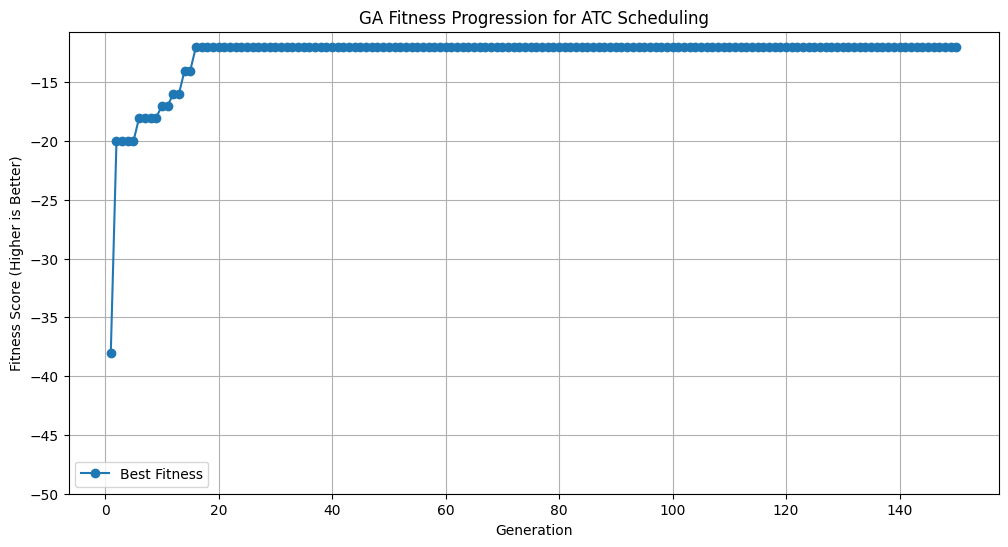

In [99]:
best_schedule, best_fitness, history = genetic_algorithm(
        population_size=POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate=CROSSOVER_RATE,
    ) # CHECK THE PARAMETERS!!! --what if i dont? what are you gonna do about it?--

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
    # Explain and show the plot
    print("\n" + "="*30)
    print("      Fitness Plot Explanation")
    print("="*30)
    print("The plot shows the fitness score evolution over generations:")
    print(" - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.")
    print(" - 'Average Fitness': The average fitness score of all schedules in the population for each generation.")
    print("Ideally, both lines should trend upwards (towards 0 or positive values).")
    print("The gap between average and best fitness indicates population diversity.")
plot_fitness(history)

# Q2 Exploring the Solution Space (5 points)

Now that you've written a base genetic algorithm, let's see what additional information you can learn about this problem. Every air traffic controller gets paid the same amount regardless of how many shifts they work. Management wants to find the minimum number of air traffic controllers they need without creating ANY constraint violations.

a. Using your genetic algorithm solver, find the minimum number of air traffic controllers needed.

b. Describe how you came up with your answer to part A and how confident you are in that answer.

# Solution 2

- a: I found that the minimum number of atc workers needed is 4.
- b: To find the minimum number of people, I decreased the `NUM_PEOPLE` parameter and ran the algorithm 3 times before I got a solution with a perfect fitness. I then decreased it again to 3, and ran the algorithm 10 times, and there was never any improvement. So, I am fairly confident in 4 being the minimum number, but it is entirely possible that there is a solution with 3 atc workers that the algorithm never got to. 

# Q3 Tweaking the Parameters (10 points)

Now that you've written a base genetic algorithm, let's see if you can improve the performance by tweaking the parameters. Pick one of the GA Parameters and create a plot showing the results at different values.


Running GA with mutation_rate = 0.0...

Running GA with mutation_rate = 0.02...

Running GA with mutation_rate = 0.04...

Running GA with mutation_rate = 0.06...

Running GA with mutation_rate = 0.08...

Running GA with mutation_rate = 0.1...

Running GA with mutation_rate = 0.2...

Running GA with mutation_rate = 0.3...

Running GA with mutation_rate = 0.4...


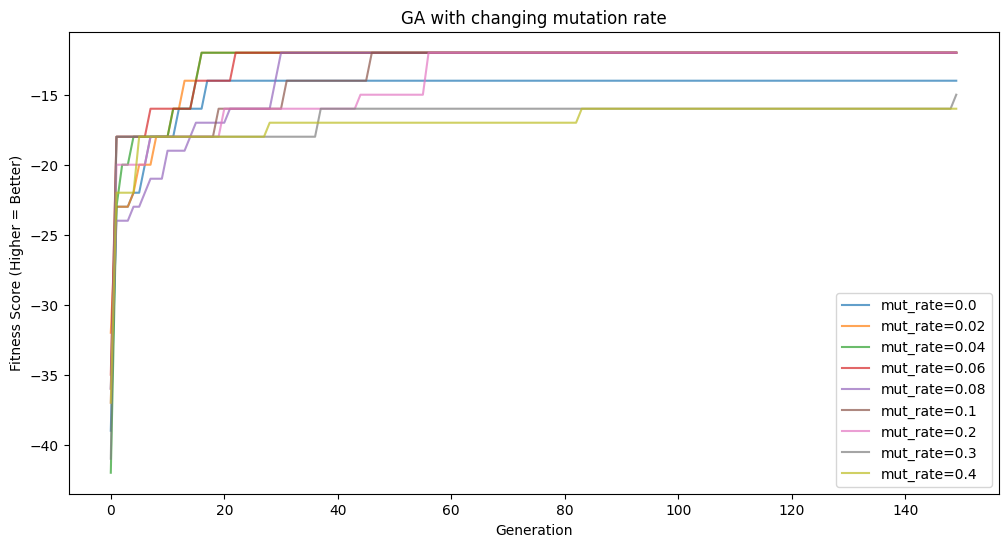

In [98]:
# define mutation rates to test
mutation_rates = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4]
fitness_histories = []

# run algorithm for each mutation rate
for mr in mutation_rates:
    print(f"\nRunning GA with mutation_rate = {mr}...")
    best_schedule, best_fitness, history = genetic_algorithm(
        population_size=POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=mr,  # Swept parameter
        crossover_rate=CROSSOVER_RATE,
    )
    fitness_histories.append(history)

# Plot comparison
plt.figure(figsize=(12, 6))
for i, mr in enumerate(mutation_rates):
    plt.plot(fitness_histories[i], label=f'mut_rate={mr}', alpha=0.7)

plt.title('GA with changing mutation rate')
plt.xlabel('Generation')
plt.ylabel('Fitness Score (Higher = Better)')
plt.legend()
plt.show()



### Interpret

- What parameter did you pick?

I picked the mutation rate

- What was optimal value for that parameter and why?

0.02 worked best as the mutation rate. I think this because it made it to the peak fitness before any of the other mutation rates, but almost all of them did make it to the peak value. I believe that 0.02 was the best value because it gives the algorithm enough mutation to never let it stagenate, but it also doesn't make the algorithm mutate so much that it can never settle to a good solution. 

- Is there another parameter do you think that tweaking it's value will improve the results and why?

I think you could make an argument that any parameter would be good to tweak, but specifically, I think that the crossover rate could make it better, for similar reasons to the mutation rate. It can really change how the algorithm comes to its solution, so it would be interesting to see what the output looks like. 

# Solution 3
Oops... I wrote it above and im too lazy to copy and paste :)

## Q4 Changing Core Operations (15 points)

Finally, we are going to explore other methods for selection, crossover, and mutation. Choose your parent selection, mutation, crossover, or selection function and rewrite it to use a different method. Then, rerun the genetic algorithm and compare the results. Display the comparisons in a graph and interpret the results. You will do this twice; you can pick two different functions or pick the same function and come up with two different versions of it.

Completely optional, but if you are look for some inspiration this paper outlines the success of different kind of selection schemes: [A Comparative Analysis of Selection Schemes
Used in Genetic Algorithms](https://www.cse.unr.edu/~sushil/class/gas/papers/Select.pdf)

- Step/Method you are replacing:

parent selection (using the tournament selection)

- Step/Method you are replacing it with:

parent selection with a roulette wheel selection (fitness proportionate)

- Interpret the results of this replacement:

I can not see any clear difference between the 2. They both level out to the same fitness (I have been testing with the 3 controller scenario because all the others get to a fitness of 0, so if I see anything get above a fitness of -12 I know something good happened)


      Best Schedule Found

Schedule (Fitness: -12.00):
      Sun | Mon | Tue | Wed | Thu | Fri | Sat
      M A N M A N M A N M A N M A N M A N M A N
      ----------------------------------------------
ATC 1: 010 010 010 101 000 010 010
ATC 2: 010 100 010 010 010 101 000
ATC 3: 101 000 101 000 101 000 101
----------------------------------------------------


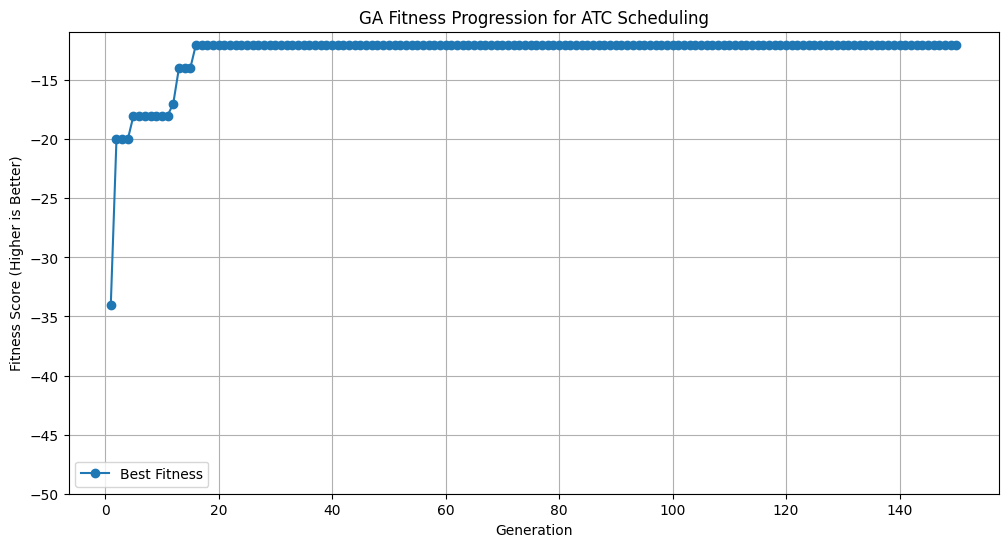


      Best Schedule Found

Schedule (Fitness: -12.00):
      Sun | Mon | Tue | Wed | Thu | Fri | Sat
      M A N M A N M A N M A N M A N M A N M A N
      ----------------------------------------------
ATC 1: 101 000 010 010 101 000 010
ATC 2: 010 010 101 000 010 100 010
ATC 3: 010 101 000 100 010 010 101
----------------------------------------------------


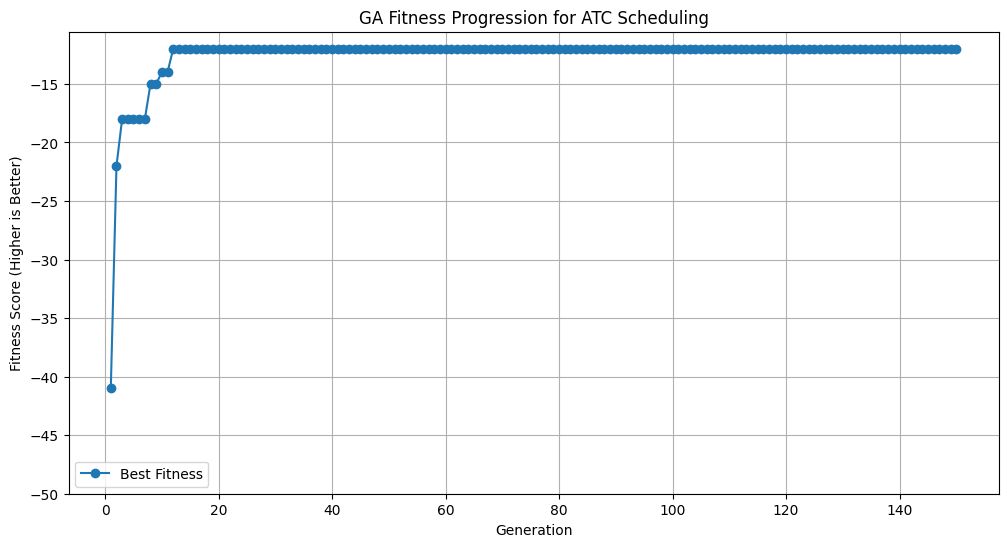

In [97]:
def parent_selection_roulette(population, fitness_scores):
    """
    selects parents using fitness proportionate selection
    """
    # Convert fitness to positive probabilities
    max_penalty = abs(min(fitness_scores)) + 1e-6
    adjusted_scores = [s + max_penalty for s in fitness_scores]
    total = sum(adjusted_scores)
    probs = [s / total for s in adjusted_scores]
    
    # selects parents
    return random.choices(population, weights=probs, k=len(population))

### Normal Run ###
best_schedule, best_fitness, history = genetic_algorithm(
        population_size=POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate=CROSSOVER_RATE,
    ) # CHECK THE PARAMETERS!!!

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
    # Explain and show the plot
    print("\n" + "="*30)
    print("      Fitness Plot Explanation")
    print("="*30)
    print("The plot shows the fitness score evolution over generations:")
    print(" - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.")
    print(" - 'Average Fitness': The average fitness score of all schedules in the population for each generation.")
    print("Ideally, both lines should trend upwards (towards 0 or positive values).")
    print("The gap between average and best fitness indicates population diversity.")
plot_fitness(history)

### roulette parent select run ###

best_schedule, best_fitness, history = genetic_algorithm(
        population_size=POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate=CROSSOVER_RATE,
        parent_func=parent_selection_roulette
    ) # CHECK THE PARAMETERS!!!

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
    # Explain and show the plot
    print("\n" + "="*30)
    print("      Fitness Plot Explanation")
    print("="*30)
    print("The plot shows the fitness score evolution over generations:")
    print(" - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.")
    print(" - 'Average Fitness': The average fitness score of all schedules in the population for each generation.")
    print("Ideally, both lines should trend upwards (towards 0 or positive values).")
    print("The gap between average and best fitness indicates population diversity.")
plot_fitness(history)


- Step/Method you are replacing:

Crossover (uniform... random shift swapping)

- Step/Method you are replacing it with:
crossover (two point)

- Interpret the results of this replacement:

Same as above, I havent seen any meaningful change in the outputs of the algorithm. I believe that if I had done a method that was completely transformative, it could have possible shown different results, but I simply havent seen that. I am still getting a max fitness of -12 for every single run. 



      Best Schedule Found

Schedule (Fitness: -12.00):
      Sun | Mon | Tue | Wed | Thu | Fri | Sat
      M A N M A N M A N M A N M A N M A N M A N
      ----------------------------------------------
ATC 1: 010 010 101 000 100 101 000
ATC 2: 010 101 000 010 010 010 010
ATC 3: 101 000 010 101 000 010 101
----------------------------------------------------


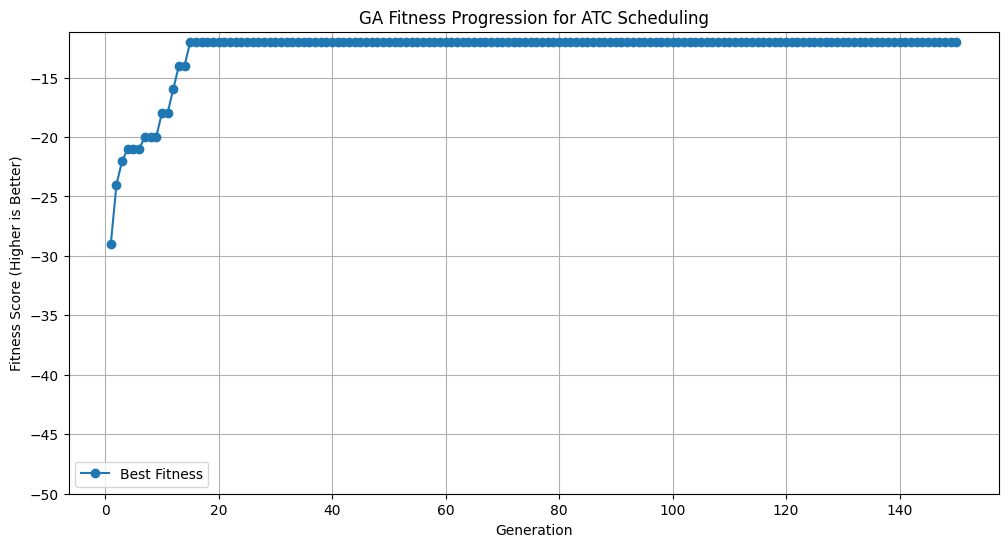


      Best Schedule Found

Schedule (Fitness: -12.00):
      Sun | Mon | Tue | Wed | Thu | Fri | Sat
      M A N M A N M A N M A N M A N M A N M A N
      ----------------------------------------------
ATC 1: 101 000 010 101 000 010 010
ATC 2: 010 100 010 010 010 101 000
ATC 3: 010 010 101 000 101 000 101
----------------------------------------------------


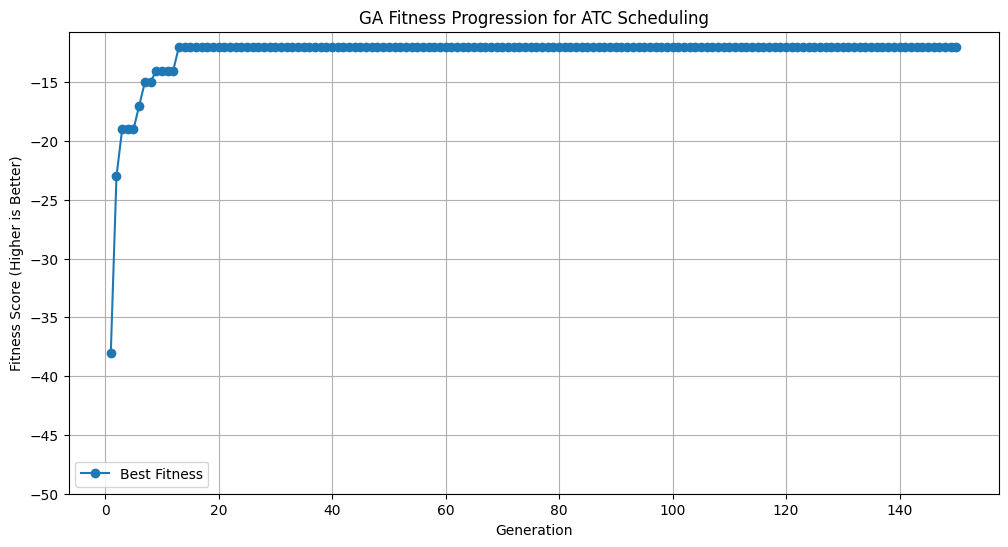

In [96]:
def two_point_crossover(parent_1, parent_2, num_people, shifts_per_week, crossover_rate):
    """
    performs two-point crossover on day blocks
    """
    if random.random() > crossover_rate:
        return parent_1.copy(), parent_2.copy()
    
    child_1 = []
    child_2 = []
    for ctrl_idx in range(num_people):
        # selects two random days as crossover points
        day_start, day_end = sorted(random.sample(range(DAYS_PER_WEEK + 1), 2))
        start_idx = day_start * SHIFTS_PER_DAY
        end_idx = day_end * SHIFTS_PER_DAY
        
        # swaps day blocks between parents
        c1 = parent_1[ctrl_idx][:start_idx] + parent_2[ctrl_idx][start_idx:end_idx] + parent_1[ctrl_idx][end_idx:]
        c2 = parent_2[ctrl_idx][:start_idx] + parent_1[ctrl_idx][start_idx:end_idx] + parent_2[ctrl_idx][end_idx:]
        
        child_1.append(c1)
        child_2.append(c2)
    
    # repair to fix rest constraints
    return repair_schedule(child_1), repair_schedule(child_2)

### Normal Run ###
best_schedule, best_fitness, history = genetic_algorithm(
        population_size=POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate=CROSSOVER_RATE,
    ) # CHECK THE PARAMETERS!!!

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
    # Explain and show the plot
    print("\n" + "="*30)
    print("      Fitness Plot Explanation")
    print("="*30)
    print("The plot shows the fitness score evolution over generations:")
    print(" - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.")
    print(" - 'Average Fitness': The average fitness score of all schedules in the population for each generation.")
    print("Ideally, both lines should trend upwards (towards 0 or positive values).")
    print("The gap between average and best fitness indicates population diversity.")
plot_fitness(history)

### two point crossover run ###

best_schedule, best_fitness, history = genetic_algorithm(
        population_size=POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate=CROSSOVER_RATE,
        cross_func=two_point_crossover,
    ) # CHECK THE PARAMETERS!!!

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
    # Explain and show the plot
    print("\n" + "="*30)
    print("      Fitness Plot Explanation")
    print("="*30)
    print("The plot shows the fitness score evolution over generations:")
    print(" - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.")
    print(" - 'Average Fitness': The average fitness score of all schedules in the population for each generation.")
    print("Ideally, both lines should trend upwards (towards 0 or positive values).")
    print("The gap between average and best fitness indicates population diversity.")
plot_fitness(history)
